## What is Offline Handwritten Text Recognition?
Offline handwriting recognition involves the automatic conversion of text in an image into letter codes that are usable within computer and text-processing applications. In simple terms, it is the text extraction from your handwritten notebooks/pages. Why called offline? The point being that there is an online text recognition system, which is referred for text that is digitally generated by using tools like stylus, apple pencil, etc.

## Approach

* **Step1** :  Build a digit(0-9) + A-Z characters classifier using a CNN architecture.
* **Step2** :  Apply character segmentation for the handwritten word image.
* **Step3** :  Classify each segmented letter and then get the final word in the image.

In [1]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=69ab652ac103b39611f21d08b2ee58e5eca1b901c2439a8122ca11602627c9c0
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [3]:
dir = "../input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [4]:
len(train_data)

140000

In [5]:
val_dir = "../input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [6]:
len(val_data)

15209

In [7]:
random.shuffle(train_data)
random.shuffle(val_data)

In [8]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [9]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [10]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [11]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [12]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [13]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [14]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "valid", activation='swish', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='swish'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='swish'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='swish'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

2022-10-30 19:31:00.978121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:31:01.072387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:31:01.073145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 19:31:01.075028: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 128)         0

In [17]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [18]:
history = model.fit(train_X,train_Y, epochs=50, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

2022-10-30 19:31:05.503377: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-30 19:31:06.918752: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4375/4375 [==============================] - 24s 4ms/step - loss: 0.5382 - accuracy: 0.8274 - val_loss: 0.2859 - val_accuracy: 0.9064
Epoch 2/50
4375/4375 [==============================] - 16s 4ms/step - loss: 0.3112 - accuracy: 0.8937 - val_loss: 0.2680 - val_accuracy: 0.9071
Epoch 3/50
4375/4375 [==============================] - 16s 4ms/step - loss: 0.2750 - accuracy: 0.9052 - val_loss: 0.2422 - val_accuracy: 0.9146
Epoch 4/50
4375/4375 [==============================] - 16s 4ms/step - loss: 0.2530 - accuracy: 0.9115 - val_loss: 0.2630 - val_accuracy: 0.9037
Epoch 5/50
4375/4375 [==============================] - 16s 4ms/step - loss: 0.2400 - accuracy: 0.9161 - val_loss: 0.2549 - val_accuracy: 0.9051
Epoch 6/50
4375/4375 [==============================] - 16s 4ms/step - loss: 0.2295 - accuracy: 0.9186 - val_loss: 0.2189 - val_accuracy: 0.9283
Epoch 7/50
4375/4375 [==============================] - 16s 4ms/step - loss: 0.2197 - accuracy: 0.9216 - val_loss: 0.2440 - val_accuracy: 0.9

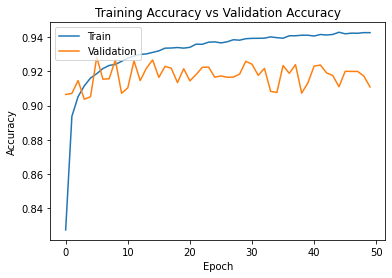

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

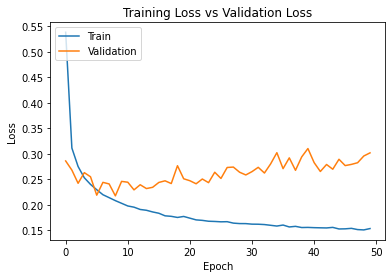

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Recognition and Post-Processing 
1. The sort contours function is used to get the correct order of individual characters for correct output extraction. In this case for extracting a single word, a left to right sorting of individual characters is needed.
2. The get letters function fetches the list of letters and get word function gets the individual word. 

In [7]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [8]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

#plt.imshow(image)

In [23]:
def get_word(letter):
    word = "".join(letter)
    return word

BTVES


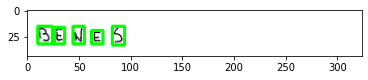

In [24]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00003.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

LIL0U


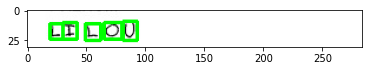

In [25]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

3AFFEUX


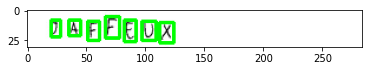

In [26]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

RUPP


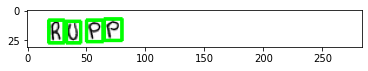

In [27]:
letter,image = get_letters("../input/handwriting-recognition/validation_v2/validation/VALIDATION_0005.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

## Drawbacks
1. The recognition part is dependent on the contour detection code, so if the opencv library is not able to find the character contour, then this method will fail.
2. There could be a lot of variation in a single handwritten letter in terms of writing style, therefore a lot more examples are needed for training this model.
3. This model will not work for connected texts like a cursive handwritten word.

## Conclusion 
This notebook is an illustration of how a character segmentation and classification approach can be used for offline handwritten text extraction. In order to improve the model, the model should be trained on the complete dataset, this notebook was trained on slightly less number of images due to session constraints. Also, for applying this method to a complete paragraph, following approach can be used, **line segmentation >> word segmentation >> character segmentation >> classification >> post-processing**. 